# 1. A description of the problem and a discussion of the background

Problem statement: Best location to open a coffee shop in Seoul, South Korea.

Coffee shop is not just a grab-and-go shop in South Korea. People in South Korea tend to spend lots of time in cafe for their work, study and meeting with friends. Unlike United States where most of cafe close before 7 PM, coffee shops in South Korea open until midnight. Even, there are more number of Starbucks in Seoul than that of in New York. Therefore, coffee shops are a hot store to open in Seoul. But you do not want to compete with 10 other stores in just one street. 

Target Audience:
What type of clients or a group of people would be interested in this project?
-Business personnel who wants to invest or open a coffee shop.
-Travelors in Seoul who wants to visit hot Cafes.
-Freelancer who would like to have their own cafes as a side business. 



# 2. A description of the data and how it will be used to solve the problem.

Data preparation: 

2.1 Scaping districts of Seoul from wikipedia.
I got a list of districts of Seoul from wikipedia ("https://en.wikipedia.org/wiki/List_of_districts_of_Seoul"). This included the name of districts, population, and area of each district. I scrapped this table using Pandas.

2.2 Getting coordinates of each district using Geopy Client. Here I am choosing top 5 districts on high population density. There should be enough consumers in the neighborhood.

2.3 Using Foursquare API to explore, segment and using KMeans to cluster the neighborhoods in Seoul based on the top 5 venues for each neighborhood district.

2.4 Analyze the clustering result and then propose some suggestion location (district) to open coffee shop in Seoul. 


## Data acquisition - 
1. Getting a list of district from Wikipedia ("https://en.wikipedia.org/wiki/List_of_districts_of_Seoul").

In [343]:
!pip install lxml 
!pip install html5lib
import pandas as pd
import html5lib

pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows', None)

There are two tables in this page. I am importing both tables separately here.

First table:

In [344]:
url='https://en.wikipedia.org/wiki/List_of_districts_of_Seoul'
df_borough=pd.read_html(url)[1]
df_borough.head()

,Name,Population,Area,Population density
0,Dobong-gu (도봉구; 道峰區),355712,20.70 km²,17184/km²
1,Dongdaemun-gu (동대문구; 東大門區),376319,14.21 km²,26483/km²
2,Dongjak-gu (동작구; 銅雀區),419261,16.35 km²,25643/km²
3,Eunpyeong-gu (은평구; 恩平區),503243,29.70 km²,16944/km²
4,Gangbuk-gu (강북구; 江北區),338410,23.60 km²,14339/km²


I selected only name before the parenthesis and change column names to 'Borough'.

In [345]:
df_borough['Name']=df_borough['Name'].apply(lambda x: x.split()[0])
df_borough.columns=['Borough','Population','Area','Population density']
df_borough.head()

,Borough,Population,Area,Population density
0,Dobong-gu,355712,20.70 km²,17184/km²
1,Dongdaemun-gu,376319,14.21 km²,26483/km²
2,Dongjak-gu,419261,16.35 km²,25643/km²
3,Eunpyeong-gu,503243,29.70 km²,16944/km²
4,Gangbuk-gu,338410,23.60 km²,14339/km²


Importing second table here with 'Name' and 'Dong' columns only.

In [346]:
url='https://en.wikipedia.org/wiki/List_of_districts_of_Seoul'
df2=pd.read_html(url)[2]
df_neighborhood=df2[['Name','Dong']]
df_neighborhood.head()

,Name,Dong
0,Dobong-gu,Dobong-dong Banghak-dong Ssangmun-dong Chang-dong
1,Dongdaemun-gu,Cheongnyangni-dong Dapsimni-dong Hoegi-dong Hwigyeong-dong Imun-dong Jegi-dong Jangan-dong Jeonnong-dong Sinseol-dong Yongdu-dong
2,Dongjak-gu,Bon-dong Daebang-dong Dongjak-dong Heukseok-dong Noryangjin-dong Sadang-dong Sangdo-dong Sindaebang-dong
3,Eunpyeong-gu,Bulgwang-dong Daejo-dong Eungam-dong Galhyeon-dong Gusan-dong Jeungsan-dong Jingwan-dong Nokbeon-dong Sinsa-dong Susaek-dong Yeokchon-dong
4,Gangbuk-gu,Mia-dong Beon-dong Suyu-dong Ui-dong


'Dong' column values were just separated by spaces. I inserted comma (',') to understand this column better.
And change column names to 'Borough' and 'Neighborhood'.

In [347]:
df_neighborhood.loc[:, 'Dong'] = df_neighborhood.Dong.apply(lambda s: s.replace(' ', ', '))
df_neighborhood.columns=['Borough','Neighborhood']
df_neighborhood.head()

/Users/jeeeonkim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Borough,Neighborhood
0,Dobong-gu,"Dobong-dong, Banghak-dong, Ssangmun-dong, Chang-dong"
1,Dongdaemun-gu,"Cheongnyangni-dong, Dapsimni-dong, Hoegi-dong, Hwigyeong-dong, Imun-dong, Jegi-dong, Jangan-dong, Jeonnong-dong, Sinseol-dong, Yongdu-dong"
2,Dongjak-gu,"Bon-dong, Daebang-dong, Dongjak-dong, Heukseok-dong, Noryangjin-dong, Sadang-dong, Sangdo-dong, Sindaebang-dong"
3,Eunpyeong-gu,"Bulgwang-dong, Daejo-dong, Eungam-dong, Galhyeon-dong, Gusan-dong, Jeungsan-dong, Jingwan-dong, Nokbeon-dong, Sinsa-dong, Susaek-dong, Yeokchon-dong"
4,Gangbuk-gu,"Mia-dong, Beon-dong, Suyu-dong, Ui-dong"


Combining two tables in one:

In [348]:
df_seoul=df_borough.merge(df_neighborhood, on='Borough')
df_seoul.head()

,Borough,Population,Area,Population density,Neighborhood
0,Dobong-gu,355712,20.70 km²,17184/km²,"Dobong-dong, Banghak-dong, Ssangmun-dong, Chang-dong"
1,Dongdaemun-gu,376319,14.21 km²,26483/km²,"Cheongnyangni-dong, Dapsimni-dong, Hoegi-dong, Hwigyeong-dong, Imun-dong, Jegi-dong, Jangan-dong, Jeonnong-dong, Sinseol-dong, Yongdu-dong"
2,Dongjak-gu,419261,16.35 km²,25643/km²,"Bon-dong, Daebang-dong, Dongjak-dong, Heukseok-dong, Noryangjin-dong, Sadang-dong, Sangdo-dong, Sindaebang-dong"
3,Eunpyeong-gu,503243,29.70 km²,16944/km²,"Bulgwang-dong, Daejo-dong, Eungam-dong, Galhyeon-dong, Gusan-dong, Jeungsan-dong, Jingwan-dong, Nokbeon-dong, Sinsa-dong, Susaek-dong, Yeokchon-dong"
4,Gangbuk-gu,338410,23.60 km²,14339/km²,"Mia-dong, Beon-dong, Suyu-dong, Ui-dong"


#### 2.2 Getting coordinates of each district using Geopy Client.

In [349]:
from geopy.geocoders import Nominatim
geolocator=Nominatim(user_agent="Seoul coffee")
df_seoul['latitude']=df_seoul['Borough'].apply(geolocator.geocode).apply(lambda x: x.latitude)
df_seoul['longitude']=df_seoul['Borough'].apply(geolocator.geocode).apply(lambda x: x.longitude)

df_seoul


,Borough,Population,Area,Population density,Neighborhood,latitude,longitude
0,Dobong-gu,355712,20.70 km²,17184/km²,"Dobong-dong, Banghak-dong, Ssangmun-dong, Chang-dong",37.668600,127.046600
1,Dongdaemun-gu,376319,14.21 km²,26483/km²,"Cheongnyangni-dong, Dapsimni-dong, Hoegi-dong, Hwigyeong-dong, Imun-dong, Jegi-dong, Jangan-dong, Jeonnong-dong, Sinseol-dong, Yongdu-dong",37.574200,127.039500
2,Dongjak-gu,419261,16.35 km²,25643/km²,"Bon-dong, Daebang-dong, Dongjak-dong, Heukseok-dong, Noryangjin-dong, Sadang-dong, Sangdo-dong, Sindaebang-dong",37.512100,126.939500
3,Eunpyeong-gu,503243,29.70 km²,16944/km²,"Bulgwang-dong, Daejo-dong, Eungam-dong, Galhyeon-dong, Gusan-dong, Jeungsan-dong, Jingwan-dong, Nokbeon-dong, Sinsa-dong, Susaek-dong, Yeokchon-dong",37.602400,126.929300
4,Gangbuk-gu,338410,23.60 km²,14339/km²,"Mia-dong, Beon-dong, Suyu-dong, Ui-dong",37.639500,127.025500
5,Gangdong-gu,481332,24.59 km²,19574/km²,"Gangil-dong, Godeok-dong, Gil-dong, Dunchon-dong, Myeongil-dong, Sangil-dong, Seongnae-dong, Amsa-dong, Cheonho-dong",37.530000,127.123700
6,Gangnam-gu,583446,39.50 km²,14771/km²,"Apgujeong-dong, Cheongdam-dong, Daechi-dong, Dogok-dong, Gaepo-dong, Irwon-dong, Jagok-dong, Nonhyeon-dong, Samseong-dong, Segok-dong, Sinsa-dong, Suseo-dong, Yeoksam-dong, Yulhyeon-dong",37.517700,127.047300
7,Gangseo-gu,591653,41.43 km²,14281/km²,"Banghwa-dong, Deungchon-dong, Gaehwa-dong, Gayang-dong, Gonghang-dong, Gwahae-dong, Hwagok-dong, Magok-dong, Naebalsan-dong, Oebalsan-dong, Ogok-dong, Osoe-dong, Yeomchang-dong",37.550900,126.849700
8,Geumcheon-gu,258030,13.02 km²,19818/km²,"Gasan-dong, Doksan-dong, Siheung-dong",37.456500,126.895400
9,Guro-gu,457131,20.12 km²,22720/km²,"Cheonwang-dong, Gaebong-dong, Garibong-dong, Gocheok-dong, Gung-dong, Guro-dong, Hang-dong, Onsu-dong, Oryu-dong, Sindorim-dong",37.495200,126.887700


Here I am choosing top 5 borough with highest population density in Seoul.

In [511]:
df_seoulsort=df_seoul.sort_values(by='Population density').reset_index(drop=True)
df_seoul5=df_seoulsort[:5]
df_seoul5

,Borough,Population,Area,Population density,Neighborhood,latitude,longitude
0,Yongsan-gu,249914,21.87 km²,11427/km²,"Cheongpa-dong, Hangangno-dong, Hannam-dong, Huam-dong, Hyochang-dong, Ichon-dong, Itaewon, Namyoung-dong, Seobinggo-dong, Wonhyoro-dong, Yongmun-dong, Yongsan-dong",37.532300,126.99000
1,Jung-gu,136227,9.96 km²,13677/km²,"Not, subdivided, into, dongs[citation, needed]",37.563656,126.99751
2,Gangseo-gu,591653,41.43 km²,14281/km²,"Banghwa-dong, Deungchon-dong, Gaehwa-dong, Gayang-dong, Gonghang-dong, Gwahae-dong, Hwagok-dong, Magok-dong, Naebalsan-dong, Oebalsan-dong, Ogok-dong, Osoe-dong, Yeomchang-dong",37.550900,126.84970
3,Gangbuk-gu,338410,23.60 km²,14339/km²,"Mia-dong, Beon-dong, Suyu-dong, Ui-dong",37.639500,127.02550
4,Gangnam-gu,583446,39.50 km²,14771/km²,"Apgujeong-dong, Cheongdam-dong, Daechi-dong, Dogok-dong, Gaepo-dong, Irwon-dong, Jagok-dong, Nonhyeon-dong, Samseong-dong, Segok-dong, Sinsa-dong, Suseo-dong, Yeoksam-dong, Yulhyeon-dong",37.517700,127.04730


#### 2.3 Using Foursquare API 

In [459]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [353]:
CLIENT_ID = 'PCGG5JQ1UW2YKG2NW0FSZES4IVYW5QVE2QJIMR0UU40SD4MO' # your Foursquare ID
CLIENT_SECRET = 'RQHJBW3DKSCCKF1P5PRSXLUSR3T0HJXO5VGADCGD5AXYNYNZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Here, I am gathering all venues in 1 km on each borough up to 100 venues.

In [354]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [355]:
seoul_venues = getNearbyVenues(names=df_seoul5['Borough'],
                                   latitudes=df_seoul5['latitude'],
                                   longitudes=df_seoul5['longitude']
                                  )

Yongsan-gu
Jung-gu
Gangseo-gu
Gangbuk-gu
Gangnam-gu


In [356]:
print(seoul_venues.shape)
seoul_venues.tail(10)

(354, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
344,Gangnam-gu,37.5177,127.0473,라우라우,37.522060,127.041281,Australian Restaurant
345,Gangnam-gu,37.5177,127.0473,Starbucks Reserve (스타벅스 리저브),37.525361,127.041525,Coffee Shop
346,Gangnam-gu,37.5177,127.0473,SOIE et ÉPICE (수아에피스),37.522616,127.040215,Thai Restaurant
347,Gangnam-gu,37.5177,127.0473,아야진 생태찌개,37.511940,127.054732,Korean Restaurant
348,Gangnam-gu,37.5177,127.0473,켄마,37.512172,127.055698,Japanese Restaurant
349,Gangnam-gu,37.5177,127.0473,Kimchee Guesthouse - Gangnam (김치게스트하우스),37.517804,127.039010,Hostel
350,Gangnam-gu,37.5177,127.0473,외고집설렁탕,37.511137,127.054347,Korean Restaurant
351,Gangnam-gu,37.5177,127.0473,오발탄,37.513607,127.053406,Korean Restaurant
352,Gangnam-gu,37.5177,127.0473,Anderson C (앤더슨씨),37.523831,127.040189,Café
353,Gangnam-gu,37.5177,127.0473,고향집,37.516796,127.037209,Korean Restaurant


In Venue category, both Café and Coffee Shop are used. To remove any complications, I am going to change 'Café' to coffee shop.

In [437]:
seoul_venues.replace("Café","Coffee Shop",inplace=True)
seoul_venues.tail(10)

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
344,Gangnam-gu,37.5177,127.0473,라우라우,37.522060,127.041281,Australian Restaurant
345,Gangnam-gu,37.5177,127.0473,Starbucks Reserve (스타벅스 리저브),37.525361,127.041525,Coffee Shop
346,Gangnam-gu,37.5177,127.0473,SOIE et ÉPICE (수아에피스),37.522616,127.040215,Thai Restaurant
347,Gangnam-gu,37.5177,127.0473,아야진 생태찌개,37.511940,127.054732,Korean Restaurant
348,Gangnam-gu,37.5177,127.0473,켄마,37.512172,127.055698,Japanese Restaurant
349,Gangnam-gu,37.5177,127.0473,Kimchee Guesthouse - Gangnam (김치게스트하우스),37.517804,127.039010,Hostel
350,Gangnam-gu,37.5177,127.0473,외고집설렁탕,37.511137,127.054347,Korean Restaurant
351,Gangnam-gu,37.5177,127.0473,오발탄,37.513607,127.053406,Korean Restaurant
352,Gangnam-gu,37.5177,127.0473,Anderson C (앤더슨씨),37.523831,127.040189,Coffee Shop
353,Gangnam-gu,37.5177,127.0473,고향집,37.516796,127.037209,Korean Restaurant


Let's count how many venues I got from each borough.

In [438]:
seoul_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Gangbuk-gu,25,25,25,25,25,25
Gangnam-gu,100,100,100,100,100,100
Gangseo-gu,29,29,29,29,29,29
Jung-gu,100,100,100,100,100,100
Yongsan-gu,100,100,100,100,100,100


#### Analyze each borough:

In [444]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")
seoul_onehot['Borough']=seoul_venues['Borough']
onehot_columns=[seoul_onehot.columns[-1]]+list(seoul_onehot.columns[:-1])
seoul_onehot=seoul_onehot[onehot_columns]

print(seoul_onehot.shape)
seoul_onehot.head()

(354, 95)


,Borough,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,...,Theater,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint
0,Yongsan-gu,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yongsan-gu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Yongsan-gu,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Yongsan-gu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Yongsan-gu,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Let's see the frequency of venues in each borough.

In [445]:
seoul_grouped=seoul_onehot.groupby('Borough').mean().reset_index()

print(seoul_grouped.shape)
seoul_grouped.head()

(5, 95)


,Borough,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Bistro,...,Theater,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint
0,Gangbuk-gu,0.00,0.00,0.00,0.00,0.00,0.040000,0.00,0.00,0.00,...,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00
1,Gangnam-gu,0.00,0.00,0.00,0.01,0.07,0.050000,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.04,0.02,0.00
2,Gangseo-gu,0.00,0.00,0.00,0.00,0.00,0.068966,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Jung-gu,0.00,0.00,0.01,0.00,0.01,0.020000,0.01,0.00,0.03,...,0.02,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
4,Yongsan-gu,0.01,0.02,0.00,0.00,0.04,0.010000,0.05,0.02,0.01,...,0.00,0.00,0.02,0.00,0.02,0.01,0.00,0.00,0.02,0.01


Here I am getting top 5 venues on each borough.

In [447]:
num_top_venues=5

for hood in seoul_grouped['Borough']:
    print("----"+hood+"----")
    temp = seoul_grouped[seoul_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Gangbuk-gu----
                  venue  freq
0           Coffee Shop  0.20
1     Korean Restaurant  0.12
2            Donut Shop  0.12
3              Bus Stop  0.08
4  Fast Food Restaurant  0.08


----Gangnam-gu----
                 venue  freq
0          Coffee Shop  0.13
1    Korean Restaurant  0.10
2            BBQ Joint  0.07
3  Japanese Restaurant  0.07
4         Dessert Shop  0.06


----Gangseo-gu----
                venue  freq
0   Korean Restaurant  0.21
1         Coffee Shop  0.17
2              Bakery  0.07
3  Italian Restaurant  0.03
4        Noodle House  0.03


----Jung-gu----
               venue  freq
0  Korean Restaurant  0.17
1        Coffee Shop  0.16
2              Hotel  0.10
3       Noodle House  0.08
4             Market  0.03


----Yongsan-gu----
                 venue  freq
0          Coffee Shop  0.14
1                  Bar  0.05
2    Korean Restaurant  0.05
3            BBQ Joint  0.04
4  Dumpling Restaurant  0.04




Let's get this information to dataframe:

In [471]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [472]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = seoul_grouped['Borough']

for ind in np.arange(seoul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gangbuk-gu,Coffee Shop,Korean Restaurant,Donut Shop,Fast Food Restaurant,Bus Stop,Bookstore,Light Rail Station,Grocery Store,Market,Convenience Store
1,Gangnam-gu,Coffee Shop,Korean Restaurant,BBQ Joint,Japanese Restaurant,Dessert Shop,Bakery,Italian Restaurant,Whisky Bar,Sushi Restaurant,Noodle House
2,Gangseo-gu,Korean Restaurant,Coffee Shop,Bakery,Noodle House,Sushi Restaurant,Bus Stop,Market,Chinese Restaurant,Clothing Store,Spa
3,Jung-gu,Korean Restaurant,Coffee Shop,Hotel,Noodle House,Bistro,Market,Pub,Italian Restaurant,Chinese Restaurant,Seafood Restaurant
4,Yongsan-gu,Coffee Shop,Korean Restaurant,Bar,BBQ Joint,Dumpling Restaurant,Cocktail Bar,Mexican Restaurant,Pizza Place,French Restaurant,Pub


Here, I can conclude that the most common venue on Gangbuk-gu, Gangnam-gu and Yongsan-gu is 'Coffee Shop'.

#### Cluster using K-means.

In [473]:
# set number of clusters
kclusters = 5

seoul_grouped_clustering = seoul_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 4, 2, 0], dtype=int32)

Making new dataframe with both borough information and 10 most common venues.

In [474]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seoul_merged = df_seoul5

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

seoul_merged.head() # check the last columns!

,Borough,Population,Area,Population density,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Yongsan-gu,249914,21.87 km²,11427/km²,"Cheongpa-dong, Hangangno-dong, Hannam-dong, Huam-dong, Hyochang-dong, Ichon-dong, Itaewon, Namyoung-dong, Seobinggo-dong, Wonhyoro-dong, Yongmun-dong, Yongsan-dong",37.532300,126.99000,0,Coffee Shop,Korean Restaurant,Bar,BBQ Joint,Dumpling Restaurant,Cocktail Bar,Mexican Restaurant,Pizza Place,French Restaurant,Pub
1,Jung-gu,136227,9.96 km²,13677/km²,"Not, subdivided, into, dongs[citation, needed]",37.563656,126.99751,2,Korean Restaurant,Coffee Shop,Hotel,Noodle House,Bistro,Market,Pub,Italian Restaurant,Chinese Restaurant,Seafood Restaurant
2,Gangseo-gu,591653,41.43 km²,14281/km²,"Banghwa-dong, Deungchon-dong, Gaehwa-dong, Gayang-dong, Gonghang-dong, Gwahae-dong, Hwagok-dong, Magok-dong, Naebalsan-dong, Oebalsan-dong, Ogok-dong, Osoe-dong, Yeomchang-dong",37.550900,126.84970,4,Korean Restaurant,Coffee Shop,Bakery,Noodle House,Sushi Restaurant,Bus Stop,Market,Chinese Restaurant,Clothing Store,Spa
3,Gangbuk-gu,338410,23.60 km²,14339/km²,"Mia-dong, Beon-dong, Suyu-dong, Ui-dong",37.639500,127.02550,1,Coffee Shop,Korean Restaurant,Donut Shop,Fast Food Restaurant,Bus Stop,Bookstore,Light Rail Station,Grocery Store,Market,Convenience Store
4,Gangnam-gu,583446,39.50 km²,14771/km²,"Apgujeong-dong, Cheongdam-dong, Daechi-dong, Dogok-dong, Gaepo-dong, Irwon-dong, Jagok-dong, Nonhyeon-dong, Samseong-dong, Segok-dong, Sinsa-dong, Suseo-dong, Yeoksam-dong, Yulhyeon-dong",37.517700,127.04730,3,Coffee Shop,Korean Restaurant,BBQ Joint,Japanese Restaurant,Dessert Shop,Bakery,Italian Restaurant,Whisky Bar,Sushi Restaurant,Noodle House


Visualization in map:

In [461]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['latitude'], seoul_merged['longitude'], seoul_merged['Borough'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, I am curious how many coffee shops in each of these boroughs. 

Here, getting dataframe only with 'Coffee shop'.

In [475]:
seoul_coffee=seoul_venues[seoul_venues['Venue Category'].apply(lambda x: x in ['Coffee Shop'])].reset_index(drop=True)
print(seoul_coffee.shape)
seoul_coffee.head()

(53, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Yongsan-gu,37.5323,126.99,Champ Coffee (챔프커피),37.532608,126.992794,Coffee Shop
1,Yongsan-gu,37.5323,126.99,Starbucks (스타벅스),37.529030,126.991544,Coffee Shop
2,Yongsan-gu,37.5323,126.99,KOHNK (코니크),37.533179,126.991190,Coffee Shop
3,Yongsan-gu,37.5323,126.99,Parched Seoul (파치드 서울),37.535217,126.988549,Coffee Shop
4,Yongsan-gu,37.5323,126.99,CHANSBROS 2 (찬스브로스),37.534767,126.987689,Coffee Shop


Count of coffee shops in each borough:

In [484]:
seoul_coffee_count=seoul_coffee.groupby('Borough').count().reset_index()
seoul_coffee_count

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gangbuk-gu,5,5,5,5,5,5
1,Gangnam-gu,13,13,13,13,13,13
2,Gangseo-gu,5,5,5,5,5,5
3,Jung-gu,16,16,16,16,16,16
4,Yongsan-gu,14,14,14,14,14,14


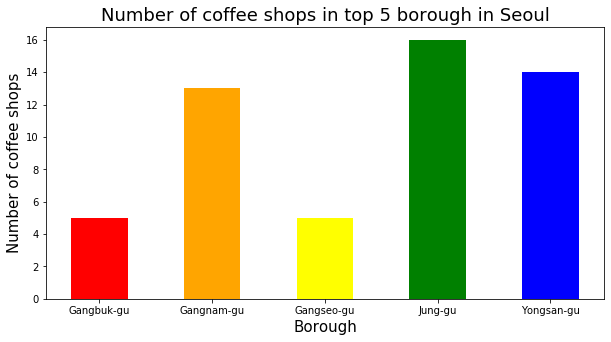

In [485]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(seoul_coffee_count['Borough'], seoul_coffee_count['Venue'],width=0.5,color=['red', 'orange', 'yellow', 'green', 'blue'])
plt.xlabel('Borough',fontsize=15)
plt.ylabel('Number of coffee shops',fontsize=15)
plt.title('Number of coffee shops in top 5 borough in Seoul',fontsize=18)
plt.show()

In [509]:
address = 'Seoul, South Korea'

geolocator = Nominatim(user_agent="seoul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_seoul2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(seoul_coffee['Borough Latitude'], seoul_coffee['Borough Longitude'], seoul_coffee['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1000,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='crimson',
        fill_opacity=0.1,
        parse_html=False).add_to(map_seoul2)  
    
map_seoul2

### Discussion:

Interestingly, the top 3 absolute number of coffee shops resulted in Gangnam-gu, Jung-gu and Yongsan-gu. We can conclude that even though Gangbuk-gu had the most frequent cafes, the absolute number is still smaller than Gangnam-gu and Yongsan-gu. But, Jung-gu had coffee shop as 2nd most common venue, but its absolute number is pretty high.
From these two analyses, my recommendation to open coffee shop is either at Gangbuk-gu or Gangseo-gu. Both boroughs have high population density in Seoul, which will attract many customers, but at the same time, competition with other coffee shops is still lower than other three boroughs.

# 3.  Conclusion 

I used python libraries, Geopy client and Foursquare API to explore top 5 boroughs in Seoul. It was very interesting to see the difference between the most frequent venue and the absolute number of coffee shops in Gangbuk-gu. Here, my recommendation to open new cafe is either Gangbuk-gu or Gangseo-gu. However, for those who would like to explore many coffee shops during the visit in Seoul, I definitely recommend Yongsan-gu and Gangnam-gu. These two boroughs had the most frequent and high number of coffee shops. It should be very convenient to explore cafes in a short, limited time during the visit.
